# Deep Homography Net

In [1]:
import glob
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

config = tf.ConfigProto()
# config.gpu_options.allocator_type = 'BFC'
tf.Session(config = config)

C:\Users\TWright\Anaconda3\envs\tensorflow-gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9883638732945203525
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3420782592
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13476775832967875521
physical_device_desc: "device: 0, name: GeForce GTX 970, pci bus id: 0000:01:00.0, compute capability: 5.2"
]


## Data Wrangling

Read the directory

In [2]:
from os import path

train_split = 0.8
valid_split = 0.2

def load_img_paths(target):
    '''
    Retrieve the full path of all images in the dataset
    '''
    return glob.glob(target + '/*.tif')

data_dir = r'../data'
original_data_dir = path.join(data_dir, 'hnet_training_112')
all_files = pd.read_csv(path.join(original_data_dir, 'homographies.tsv'), sep='\t')
all_files.head()

,Unnamed: 0,fname,h
0,0,Tp26_Y000_X000_040_0000,"2.5,25.5,18.5,-10.5,-7.0,-14.5,-20.5,20.0"
1,1,Tp26_Y000_X000_040_0001,"-1.5,-27.0,22.5,-21.5,21.5,-11.0,-18.0,-9.5"
2,2,Tp26_Y000_X000_040_0002,"-4.5,-15.0,-13.5,-7.5,25.5,-14.5,-18.0,28.0"
3,3,Tp26_Y000_X000_040_0003,"24.5,-20.5,-28.0,-22.0,-20.5,-25.0,24.0,-15.0"
4,4,Tp26_Y000_X000_040_0004,"-8.0,25.5,27.5,22.0,24.5,20.0,-26.5,18.5"


In [3]:
all_files = all_files.sample(frac=1, random_state=123) # shuffle with seed 123 for reproducability
train_paths = []
valid_paths = []

if train_split <= 1:
    frac = int(all_files.shape[0] * train_split)
    train_paths = all_files[:frac].values.tolist()
    valid_paths = all_files[frac:].values.tolist()
else:
    valid_frac = int(train_split * valid_split)
    train_paths = all_files[:train_split].values.tolist()
    valid_paths = all_files[train_split:train_split+valid_frac].values.tolist()

assert(len(train_paths) > 0)
print('Traning images:    %d' % len(train_paths))
print('Validation images: %d' % len(valid_paths))

Traning images:    48000
Validation images: 12000


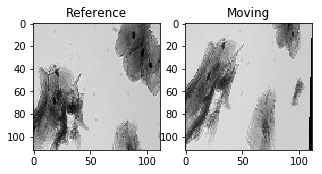

In [4]:
import matplotlib.pylab as plt
%matplotlib inline

def two_up(ref, mov):
    fig, (a, b) = plt.subplots(1, 2, figsize=(5, 8))
    a.imshow(ref, cmap='gray')
    a.set_title('Reference')
    b.imshow(mov, cmap='gray')
    b.set_title('Moving')
    plt.show()

from imageio import imread
tm1 = imread(original_data_dir + '/Tp26_Y000_X000_040_0005_A.tif')
tm2 = imread(original_data_dir + '/Tp26_Y000_X000_040_0005_B.tif')
two_up(tm1, tm2)

## HomographyNet

Regression variant

> We use 8 convolutional layers with a max pooling layer (2x2, stride 2) after every two convolutions. The 8 convolutional layers have the following number of filters per layer: 64 [x4], 128 [x4]. The convolutional layers are followed by two fully connected layers. The first fully connected layer has 1024 units. Dropout with a probability of 0.5 is applied after the final convolutional layer and the first fully-connected layer.

> The regression network directly produces 8 real-valued
numbers and uses the Euclidean (L2) loss as the final layer
during training.

> using stochastic gradient descent (SGD) with momentum of 0.9. We use a base learning rate of 0.005 and decrease the learning rate by a factor of 10 after every 30,000 iterations.

In [5]:
from keras.models import Sequential, Model
from keras.layers import BatchNormalization, Dense, Flatten, MaxPooling2D, Input, Activation, Dropout
from keras.layers.convolutional import Conv2D
import keras.backend as K

def euclidean_distance(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1, keepdims=True))

def conv_block(m, filters):
    kernel = (3, 3)
    m = Conv2D(filters, kernel, padding='same', activation='relu')(m)
    m = Conv2D(filters, kernel, padding='same', activation='relu')(m)
    m = BatchNormalization()(m)
    return MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(m)

def homography_regression_model(input_dims):
    input_shape=(*input_dims, 2)
    
    input_layer = Input(shape=input_shape, name='input_layer')
    
    # 4x 64
    x = conv_block(input_layer, 64)
    x = conv_block(x,           64) 
    # 4x 128
    x = conv_block(x,           128)
    x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1024, name='FC_1024')(x)
    x = Dropout(0.5)(x)
    
    out = Dense(8, name='output')(x)
    
    return Model(inputs=input_layer, outputs=[out])

Using TensorFlow backend.


In [6]:
from keras.optimizers import SGD

img_size = tm1.shape[:2]

# opt = SGD(lr=0.005, momentum=0.9, decay=0.0015)
opt = SGD(lr=0.005, momentum=0.9, decay=0.0)

my_model = homography_regression_model(img_size)
my_model.compile(optimizer=opt, loss=euclidean_distance)
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 112, 112, 2)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      1216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 64)        36928     
__________

## Data Generators

We generate the "seemingly infinite training data" on the fly by using Keras' DataGenerators.

In [7]:
import math
from os import path
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, LearningRateScheduler
from keras.preprocessing.image import img_to_array, load_img
from keras.utils import Sequence
from skimage.transform import rotate


def h_string_to_arr(s):
    return np.array(list(map(lambda x: np.float32(x), s.split(','))))
    

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
class DataGenerator(Sequence):
    '''
    Adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html
    Allows for multiprocessing in the fit generator
    '''

    def __init__(self, train_set, batch_size, im_size, train_dir):
        self.train = train_set
        self.batch_size = batch_size
        self.im_size = im_size
        self.train_dir = train_dir

    def __len__(self):
        return int(np.ceil(len(self.train) / float(self.batch_size)))

    def read_images(self, fname):
        ext = '.tif'
        base = path.join(self.train_dir, fname)
        a = img_to_array(load_img(base + '_A' + ext, grayscale=True))
        b = img_to_array(load_img(base + '_B' + ext, grayscale=True))
        return np.dstack((a,b))
    
    # Will output sequence of tuples (image, test) given a datapath
    def __getitem__(self, idx):
        X = np.zeros(shape=(batch_size, self.im_size[0], self.im_size[1], 2))
        y = np.zeros(shape=(batch_size, 8))
        batch = self.train[idx * self.batch_size:(idx + 1) * self.batch_size]
        for j,row in enumerate(batch):
            fname, h_str = row[1:]
            X[j] = self.read_images(fname)
            y[j] = h_string_to_arr(h_str)
        return (X, y)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

# create weights file if it doesn't exist for ModelCheckpoint
from os import mkdir
try: 
    mkdir('tmp')
except FileExistsError:
    print('tmp directory already exists')

history = LossHistory()

def step_scheduler(epoch, lr):
    step1 = int(epochs/3)
    step2 = step1 * 2
    if epoch == step1 or epoch == step2:
        return lr * 0.1 # decrease by a factor of 10
    return lr # no change

lrScheduler = LearningRateScheduler(step_scheduler)

tmp directory already exists


## Training

> We use a base learning rate of 0.005 and decrease the learning rate by a factor of 10 after every 30,000 iterations.The networks are trained for for 90,000 total iterations using a batch size of 64.


In [11]:
batch_size = 32
total_iterations = 60000

steps_per_epoch  = int(len(train_paths) / batch_size)
validation_steps = int(len(valid_paths) / batch_size)

epochs = int(total_iterations / steps_per_epoch)

training_generator   = DataGenerator(train_paths, batch_size, img_size, original_data_dir)
validation_generator = DataGenerator(valid_paths, batch_size, img_size, original_data_dir)

# descriptive weight file naming
checkpointer = ModelCheckpoint(filepath=('tmp/weights-%d-%d.hdf5' % 
                                         (batch_size, img_size[0])), 
                               verbose=1, save_best_only=True)

print('Epochs:            %d' % epochs)
print('Traning images:    %d' % len(train_paths))
print('Validation images: %d' % len(valid_paths))
print('Training steps:    %d' % steps_per_epoch)
print('Validation steps:  %d' % validation_steps)

Epochs:            40
Traning images:    48000
Validation images: 12000
Training steps:    1500
Validation steps:  375


In [12]:
hist = my_model.fit_generator(training_generator,
                              validation_data=validation_generator,
                              epochs=epochs,
                              workers=3,
                              verbose=2,
                              callbacks=[history, checkpointer, early_stopping, lrScheduler]
                             )

Epoch 1/40
 - 298s - loss: 33.4998 - val_loss: 33.3559

Epoch 00001: val_loss improved from inf to 33.35592, saving model to tmp/weights-32-112.hdf5
Epoch 2/40
 - 296s - loss: 25.7582 - val_loss: 25.7131

Epoch 00002: val_loss improved from 33.35592 to 25.71310, saving model to tmp/weights-32-112.hdf5
Epoch 3/40
 - 298s - loss: 23.5004 - val_loss: 36.4384

Epoch 00003: val_loss did not improve from 25.71310
Epoch 4/40
 - 291s - loss: 22.0006 - val_loss: 30.3388

Epoch 00004: val_loss did not improve from 25.71310
Epoch 5/40
 - 293s - loss: 20.9787 - val_loss: 48.1290

Epoch 00005: val_loss did not improve from 25.71310
Epoch 6/40
 - 293s - loss: 20.2872 - val_loss: 37.8896

Epoch 00006: val_loss did not improve from 25.71310
Epoch 7/40
 - 296s - loss: 19.7223 - val_loss: 19.0693

Epoch 00007: val_loss improved from 25.71310 to 19.06933, saving model to tmp/weights-32-112.hdf5
Epoch 8/40
 - 283s - loss: 19.1061 - val_loss: 26.1090

Epoch 00008: val_loss did not improve from 19.06933
Epo

## Results inspection

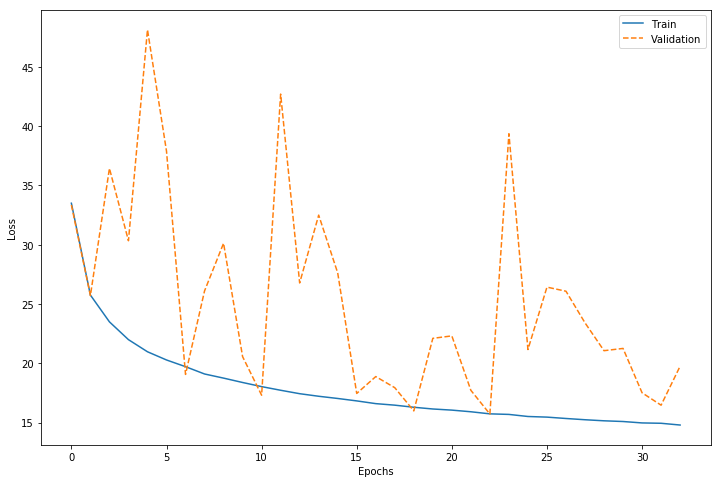

In [13]:
plt.figure(figsize=(12,8))
plt.plot(hist.epoch,hist.history['loss'],    label='Train')
plt.plot(hist.epoch,hist.history['val_loss'],label='Validation',linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

[[ 10.843596  -12.990722 ]
 [ 10.283024    4.1074615]
 [ -8.942861  -13.792135 ]
 [ -7.950973   37.22997  ]] 

 [[ 18.5 -14.5]
 [ 25.   -4. ]
 [ 16.  -17. ]
 [ -4.   25.5]]


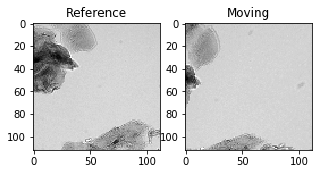

In [29]:
import cv2
from numpy.random import randint
from skimage.transform import resize

def alter_pt(pt, r):
    return (pt[0] + randint(-r,r), pt[1] + randint(-r,r))

def create_patch(im, size, r):
    '''
    Create pairs of patches from an image
    '''
    while True:
        # generate four random points
        x = randint(0, im.shape[1]-size)
        y = randint(0, im.shape[0]-size)
        tl = (x,y)
        tr = (tl[0], tl[1]+size)
        br = (tl[0]+size, tl[1]+size)
        bl = (tl[0]+size, tl[1])
        A = im[y:y+size,x:x+size] # this is our 'reference' image
        # alter points randomly by rho
        tl2 = alter_pt(tl, r)
        tr2 = alter_pt(tr, r)
        br2 = alter_pt(br, r)
        bl2 = alter_pt(bl, r)
        perturbed = np.float32([tl2, tr2, br2, bl2])
        # transform
        H = cv2.getPerspectiveTransform(np.float32([tl, tr, br, bl]), perturbed)
        Hab = np.linalg.inv(H) 
        # warp image
        full_warped = cv2.warpPerspective(im, Hab, im.shape, flags=cv2.INTER_NEAREST)
        B = full_warped[y:y+size,x:x+size]
        if A.shape == B.shape and A.mean() < 210:
            return A, B, np.subtract(perturbed, [tl, tr, br, bl])/2
    
test_dir = r'../data/learning'
im1 = imread(test_dir + '/Tp26_Y000_X002_040.tif')
im1 = cv2.resize(im1, (672,512), interpolation=cv2.INTER_NEAREST)

p_a, p_b, H_act = create_patch(im1, 224, 56)
p_a = cv2.resize(p_a, img_size, interpolation=cv2.INTER_NEAREST)
p_b = cv2.resize(p_b, img_size, interpolation=cv2.INTER_NEAREST)

test_im = np.dstack((p_a, p_b))
test_im = test_im.reshape(1, *test_im.shape)
H_pred = my_model.predict(test_im)
print(H_pred.reshape(4,2), '\n\n', H_act.reshape(4,2))
two_up(p_a, p_b)